# 2nd order optimization of neural nets using Gauss Newton

In this notebook we will show to easily build 2nd order optimizers using cola.

First let's generate a suitable classification dataset.


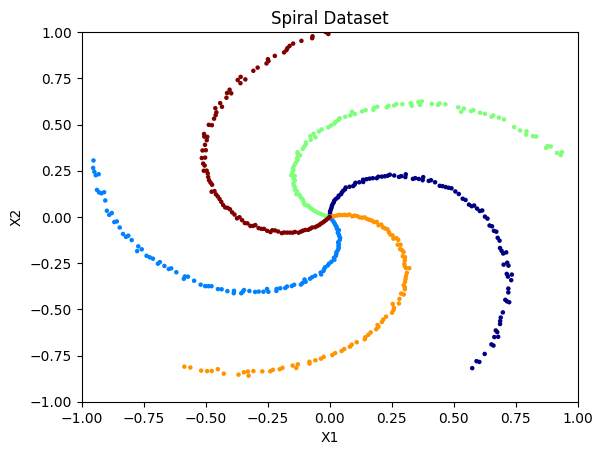

In [1]:
%load_ext autoreload
%autoreload 2

# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Function to generate the spiral dataset
def generate_spiral_data(n_points, n_spirals, noise=0.02):
    X = np.zeros((n_points * n_spirals, 2))
    y = np.zeros(n_points * n_spirals, dtype=int)
    delta_theta = 4 * np.pi / n_spirals
    for i in range(n_spirals):
        theta = np.linspace(i * delta_theta, (i + 1) * delta_theta, n_points)
        r = np.linspace(0.0, 1, n_points)
        t = theta + np.random.randn(n_points) * noise
        X[i * n_points:(i + 1) * n_points] = np.column_stack((r * np.sin(t), r * np.cos(t)))
        y[i * n_points:(i + 1) * n_points] = i
    return X, y

# Generating the spiral dataset with 100 points and 5 spirals
n_points = 100
n_spirals = 5
X, y = generate_spiral_data(n_points, n_spirals)

# Plotting the spiral dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet', s=5)
plt.title('Spiral Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [147]:
import torch
import torch.nn as nn
import torch.optim as optim
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
def MLP(k=100):
    return nn.Sequential(
                nn.Linear(2, k), nn.SiLU(),
                nn.Linear(k, k), nn.SiLU(),
                nn.Linear(k, n_spirals))
                

/tmp/ipykernel_901381/4056217831.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_901381/4056217831.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


First lets train using 1000 epochs of Adam

In [155]:
learning_rate = 2.5
epochs = 500

model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

sgd_losses = []
for epoch in range(epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sgd_losses.append(loss.item())
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')


Epoch [100/500], Loss: 0.15951479971408844
Epoch [200/500], Loss: 0.09044767916202545
Epoch [300/500], Loss: 0.07529468089342117
Epoch [400/500], Loss: 0.0655708909034729
Epoch [500/500], Loss: 0.061970748007297516


Now lets make a 2nd order method using cola, here we will use the Gauss-Newton PSD approximation to the Hessian.

First let's make it so we can call as an explicit function of it's parameters (like in jax).

In [4]:
import torch.func as tf

def flatten_params(params):
    shapes = [p.shape for p in params]
    flat_params = torch.cat([p.flatten() for p in params])
    return flat_params, shapes


def unflatten_params(flat_params, shapes):
    params = []
    i = 0
    for shape in shapes:
        size = torch.prod(torch.tensor(shape)).item()
        param = flat_params[i:i + size]
        param = param.view(shape)
        params.append(param)
        i += size
    return params

model = MLP()
flat_p, shape = flatten_params(list(model.parameters()))
flat_p = flat_p.detach().requires_grad_(True)

def stateless_model(flatparams, x):
    params = unflatten_params(flatparams, shape)
    names = list(n for n, _ in model.named_parameters())
    nps = {n: p for n, p in zip(names, params)}
    return tf.functional_call(model, nps, x)

Now let's construct the Gauss Newton matrix to use as a PSD proxy for the Hessian in Newtons method.

$G = \frac{1}{n}\sum_i J(x_i)^TJ(x_i)$ where $J\in \mathbb{R}^{C \times p}$ is the Jacobian of the network for a single data point, $p$ is the number of parameters and $C$ is the number of outputs (classes).

Note: A better approximation to the full Hessian is to include the Hessian of the loss with respect to the network outputs:
$G' = \frac{1}{n}\sum_i J(x_i)^THJ(x_i)$ and we will also try this.

If we write the $J(X) \in \mathbb{R}^{nC \times p}$ to be the Jacobian of the network for the entire dataset $X=\{x_i\}_{i=1}^n$, we can write
$G = J(X)^TJ(X)/n$.

and 
$G' = J(X)^THJ(X)$ (we can ignore the $1/n$ scaling because that is already present in the loss function.)

Here we will annotate the matrix as PSD so as to enable more efficient inversion methods, and we will add a small amount of Tikhonov regularization to the diagonal to improve the conditioning.

In [129]:
import cola

def flat_fn(p):
    return stateless_model(p, X).reshape(-1)

def GN(p):
    """Gauss-Newton approximation to the Hessian"""
    J = cola.ops.Jacobian(flat_fn, p)
    G = J.T @ J/ X.shape[0]
    return cola.PSD(G+1e-4*cola.ops.I_like(G))

def GNH(p):
    J = cola.ops.Jacobian(flat_fn, p)
    H = cola.ops.Hessian(lambda z: criterion(z.reshape(X.shape[0],-1),y)*n_spirals, flat_fn(p))
    G = J.T @ H @ J
    return cola.PSD(G+1e-4*cola.ops.I_like(G))

def flat_loss(params):
    return criterion(flat_fn(params).reshape(X.shape[0],-1), y)

Below we implement the optimization loop in this stateless manner.

We limit the tolerance and max iterations of the (iterative) solves so as to reduce the computation time. Though we don't do so here, adding a preconditioner (e.g. Jacobi, PivotedCholesky, Nystrom) would substantially accelerate the convergence of the solves.
Let's compare the two second order methods:

In [136]:
# Method 1: Gauss Newton
p = flat_p.clone()

gn_losses = []
for epoch in range(epochs//2):
    g = torch.autograd.grad(flat_loss(p), p)[0]
    p -= cola.inverse(GN(p),tol=1e-3, max_iters=20) @ g

    loss = flat_loss(p)
    gn_losses.append(loss.item())
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')

Epoch [50/500], Loss: 0.10672428458929062
Epoch [100/500], Loss: 0.07033566385507584
Epoch [150/500], Loss: 0.056416552513837814
Epoch [200/500], Loss: 0.048720236867666245
Epoch [250/500], Loss: 0.04361817613244057


In [134]:
# Method 2: Hessian weighted Gauss Newton
p = flat_p.clone()

gnh_losses = []
for epoch in range(epochs//5):
    g = torch.autograd.grad(flat_loss(p), p)[0]
    p -= cola.inverse(GNH(p),tol=1e-3, max_iters=20) @ g

    loss = flat_loss(p)
    gnh_losses.append(loss.item())
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')

Epoch [5/500], Loss: 0.6411073207855225
Epoch [10/500], Loss: 0.29395291209220886
Epoch [15/500], Loss: 0.15232253074645996
Epoch [20/500], Loss: 0.08573848009109497
Epoch [25/500], Loss: 0.05266304314136505
Epoch [30/500], Loss: 0.0354301780462265
Epoch [35/500], Loss: 0.02600720524787903
Epoch [40/500], Loss: 0.020926931872963905
Epoch [45/500], Loss: 0.01838609203696251
Epoch [50/500], Loss: 0.017106657847762108
Epoch [55/500], Loss: 0.016634656116366386
Epoch [60/500], Loss: 0.016393646597862244
Epoch [65/500], Loss: 0.016267376020550728
Epoch [70/500], Loss: 0.016196906566619873
Epoch [75/500], Loss: 0.016154292970895767
Epoch [80/500], Loss: 0.0161337498575449
Epoch [85/500], Loss: 0.0161212719976902
Epoch [90/500], Loss: 0.016113845631480217
Epoch [95/500], Loss: 0.016109218820929527
Epoch [100/500], Loss: 0.016106147319078445


We can see that the 2nd order methods converges much faster per iteration than first order gradient descent, with the Hessian weighted Gauss Newton performing the best. Try playing around with the gradient descent learning rate to see.

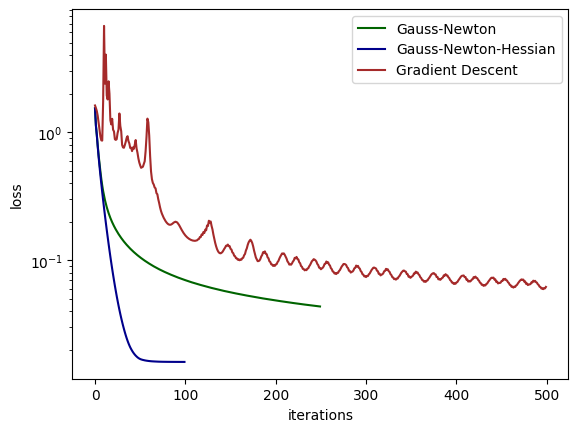

In [156]:
# choose some nice colors for the plot
plt.plot(gn_losses, label='Gauss-Newton', color='darkgreen')
plt.plot(gnh_losses, label='Gauss-Newton-Hessian', color='darkblue')
plt.plot(sgd_losses, label='Gradient Descent', color='brown')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()

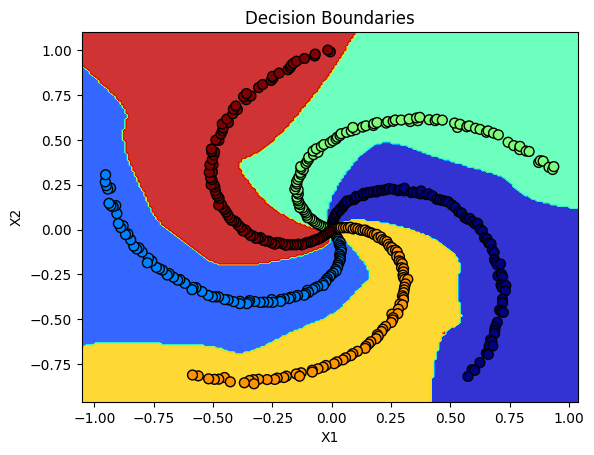

In [140]:
def plot_decision_boundary(model, X, y):
    # Creating a mesh grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predicting the class labels for the mesh grid
    Z = stateless_model(p, torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
    Z = torch.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    # Plotting the decision boundaries
    plt.contourf(xx, yy, Z.detach().numpy(), alpha=0.8, cmap='jet')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, linewidth=1, cmap='jet')
    plt.xlim(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    plt.ylim(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)
    plt.title('Decision Boundaries')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

# Plotting the decision boundaries
plot_decision_boundary(model, X, y)